# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [97]:
os.listdir("./")

['.DS_Store',
 'modeling_covics_eindhoven.ipynb',
 'figs',
 'code',
 '.gitmodules',
 'results',
 '.gitignore',
 '.ipynb_checkpoints',
 'modeling_covics.ipynb',
 'data']

In [98]:
data_dir = "../../COVID-19/csse_covid_19_data/"

In [99]:
# Load the start of these datasets
#covid_confirmed.head()
#covid_deaths.head()
#covid_recovered.head()

In [100]:
# Load datasets

covid_confirmed = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [101]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)-4}')

Total number of days in database: 67


In [ ]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [ ]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [ ]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [ ]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

In [ ]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [ ]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [ ]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [ ]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [ ]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [ ]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [ ]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

In [ ]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [ ]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

In [ ]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

In [ ]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

In [ ]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

## Fit Hopkins data ## 

In [ ]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

In [ ]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

    

## Prediction for the next 3 weeks ## 

In [ ]:
days = len(covid_confirmed.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Deaths

In [ ]:
def plotDeaths(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Deaths']
    co = co.loc[co['Deaths'] > 0]
    
    y = np.array(co['Deaths'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed deaths on',co.index[-1],'\t',current)
            print('\tConfirmed deaths on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed deaths")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected deaths (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected deaths (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Deaths. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Deaths', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

In [ ]:
days = len(covid_deaths.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
deaths = covid_deaths.iloc[:,[1,-1]].groupby('Country/Region').sum()
deaths = deaths.sort_values(by = mostrecentdate, ascending = False)
deaths = deaths[deaths[mostrecentdate] >= 100]

topcountries = deaths.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotDeaths(covid_deaths, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_deaths[covid_deaths['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted deaths (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_deaths[covid_deaths['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted deaths (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Deaths. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Deaths', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Recovery

In [ ]:
def plotRecovered(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Recovered']
    co = co.loc[co['Recovered'] > 0]
    
    y = np.array(co['Recovered'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed recovered on',co.index[-1],'\t',current)
            print('\tConfirmed recovered on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed recovered")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected recovered (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected recovered (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Recovered. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Recovered', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

In [ ]:
days = len(covid_recovered.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
recovered = covid_recovered.iloc[:,[1,-1]].groupby('Country/Region').sum()
recovered = recovered.sort_values(by = mostrecentdate, ascending = False)
recovered = recovered[recovered[mostrecentdate] >= 100]

topcountries = recovered.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotRecovered(covid_recovered, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_recovered[covid_recovered['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted recovered (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_recovered[covid_recovered['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted recovered (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Recovered. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Recovered', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    


# Testing predictions on left-out data

In [128]:
def plotCasesLO(dataframe, column, country, days):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    # same as before, but we hold out days
    
    print('\nLeaving out:',days,'days')
    y_lo = y[:-days] # hold out x days from the data
    x_lo = np.arange(y_lo.size)

    try:
        lpopt, lpcov = curve_fit(logistic, x_lo, y_lo, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y_lo - logistic(x_lo, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_lo - np.mean(y_lo))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        print(logisticr2)
        if logisticr2 > 0.95:
            plt.plot(x_lo, logistic(x_lo, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
            
            # now we apply the model to the final x days and check the accuracy
            test_days = list(range(max(x_lo),max(x),1))
            preds = [logistic(t, lpopt[0], lpopt[1], lpopt[2],lpopt[3]) for t in test_days]
            preds = np.asarray(preds)

            test_set_residuals = y[len(y) - days:] - preds
            ss_res_test = np.sum(test_set_residuals**2)
            ss_tot_test = np.sum((y[len(y) - days:] - np.mean(y[len(y) - days:]))**2)
            logisticr2test = 1 - (ss_res_test/ss_tot_test)

           
            plt.plot(test_days,preds,'b--',label="Applied to held-out data (logistic)")
            print('\tR^2 (test set):', logisticr2test)
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x_lo, y_lo, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y_lo - exponential(x_lo, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_lo - np.mean(y_lo))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x_lo, exponential(x_lo, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            test_days = list(range(max(x_lo),max(x),1))
            preds = [exponential(t, epopt[0], epopt[1], epopt[2]) for t in test_days]
            preds = np.asarray(preds)

            test_set_residuals = y[len(y) - days:] - preds
            ss_res_test = np.sum(test_set_residuals**2)
            ss_tot_test = np.sum((y[len(y) - days:] - np.mean(y[len(y) - days:]))**2)
            expr2test = 1 - (ss_res_test/ss_tot_test)

            
            plt.plot(test_days,preds,'c--',label="Applied to held-out data (exponential)")
            print('\tR^2 (test set):', expr2test)
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        print("Modelling failed to produce accurate (>0.95) results")
        return [float('NaN'), float('NaN'), recentdbltime,float('NaN')]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 121478
	Confirmed cases on 3/21/20 	 25489
	Ratio: 4.77
	Weekly increase: 376.6 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

Leaving out: 3 days

** Based on Exponential Fit **

	R^2: 0.9953592575600287
	Doubling Time (represents overall growth):  2.65 (± 0.09 ) days
	R^2 (test set): 0.42290080306594713


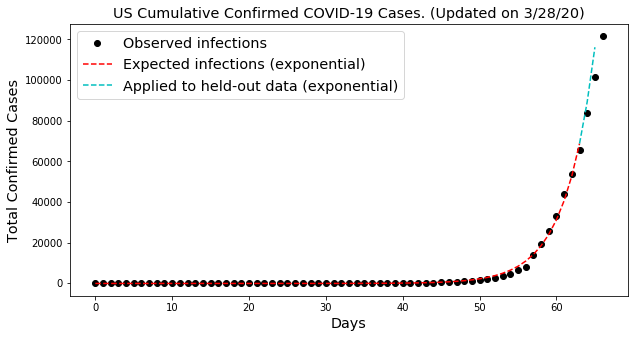



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 92472
	Confirmed cases on 3/21/20 	 53578
	Ratio: 1.73
	Weekly increase: 72.6 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

Leaving out: 3 days
0.9994906632530531

** Based on Logistic Fit**

	R^2: 0.9994906632530531
	Doubling Time (during middle of growth):  7.03 (± 0.23 ) days
	R^2 (test set): -1.2260342954778145

** Based on Exponential Fit **

	R^2: 0.9899632560315086
	Doubling Time (represents overall growth):  5.48 (± 0.33 ) days
	R^2 (test set): -1.5938275361597114


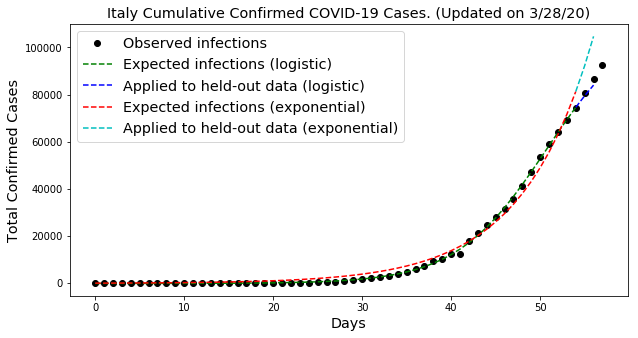



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 81999
	Confirmed cases on 3/21/20 	 81305
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 570.9 days

Leaving out: 3 days
0.9955976860959642

** Based on Logistic Fit**

	R^2: 0.9955976860959642
	Doubling Time (during middle of growth):  6.49 (± 0.5 ) days
	R^2 (test set): -72.24959796544734


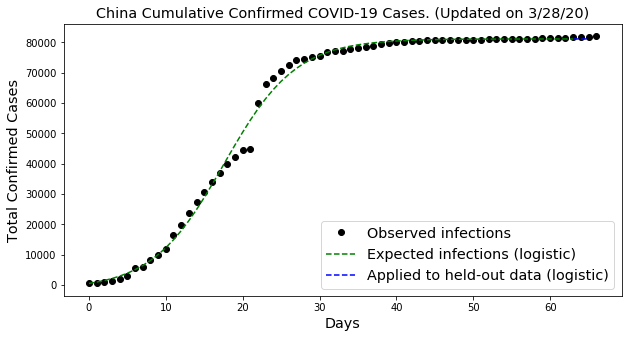



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 73235
	Confirmed cases on 3/21/20 	 25374
	Ratio: 2.89
	Weekly increase: 188.6 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

Leaving out: 3 days

** Based on Exponential Fit **

	R^2: 0.9960038402483921
	Doubling Time (represents overall growth):  3.74 (± 0.14 ) days
	R^2 (test set): 0.22684622925261155


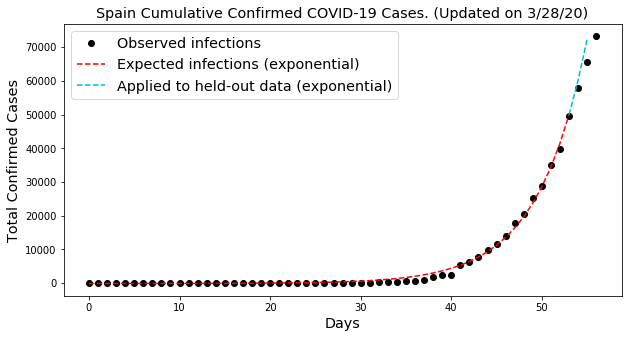



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 57695
	Confirmed cases on 3/21/20 	 22213
	Ratio: 2.6
	Weekly increase: 159.7 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

Leaving out: 3 days
0.998978633944572

** Based on Logistic Fit**

	R^2: 0.998978633944572
	Doubling Time (during middle of growth):  4.79 (± 0.21 ) days
	R^2 (test set): -3.3473020815680803

** Based on Exponential Fit **

	R^2: 0.9897013149706683
	Doubling Time (represents overall growth):  3.97 (± 0.22 ) days
	R^2 (test set): 0.7100521656712284


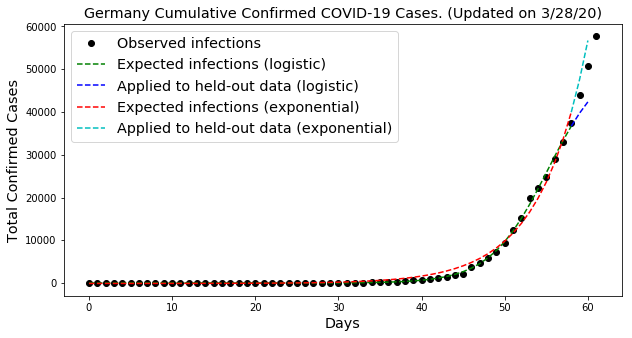

In [129]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCasesLO(covid_confirmed, 'Country/Region', c,3)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

    